In [52]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from pyia import GaiaData

In [76]:
rrl = at.Table.read('../data/pal5/RRL-with-prob.fits')
rrl = rrl[(rrl['member_prob'] > 0.5) & rrl['inside_stream_track']]
rrl = GaiaData(rrl)
rrl_c = rrl.get_skycoord(distance=rrl.D_ps1*u.kpc)
rrl_pal5_c = rrl_c.transform_to(gc.Pal5)
rrl_pm_cov = rrl.get_cov()[:, 3:5, 3:5]
rrl_pm_cov_pal5 = gc.transform_pm_cov(rrl_c, rrl_pm_cov, to_frame=gc.Pal5)

rgb = GaiaData('../data/pal5/ibata2017_with_gaia.csv')
rgb_c = rgb.get_skycoord(distance=False,
                         radial_velocity=rgb.vhelio*u.km/u.s)
rgb_pal5_c = rgb_c.transform_to(gc.Pal5)
rgb_pm_cov = rgb.get_cov()[:, 3:5, 3:5]
rgb_pm_cov_pal5 = gc.transform_pm_cov(rgb_c, rgb_pm_cov, to_frame=gc.Pal5)

pm_mask = np.sqrt((rgb.pmra - rrl.pmra.mean())**2 + (rgb.pmdec - rrl.pmdec.mean())**2) < 1.*u.mas/u.yr

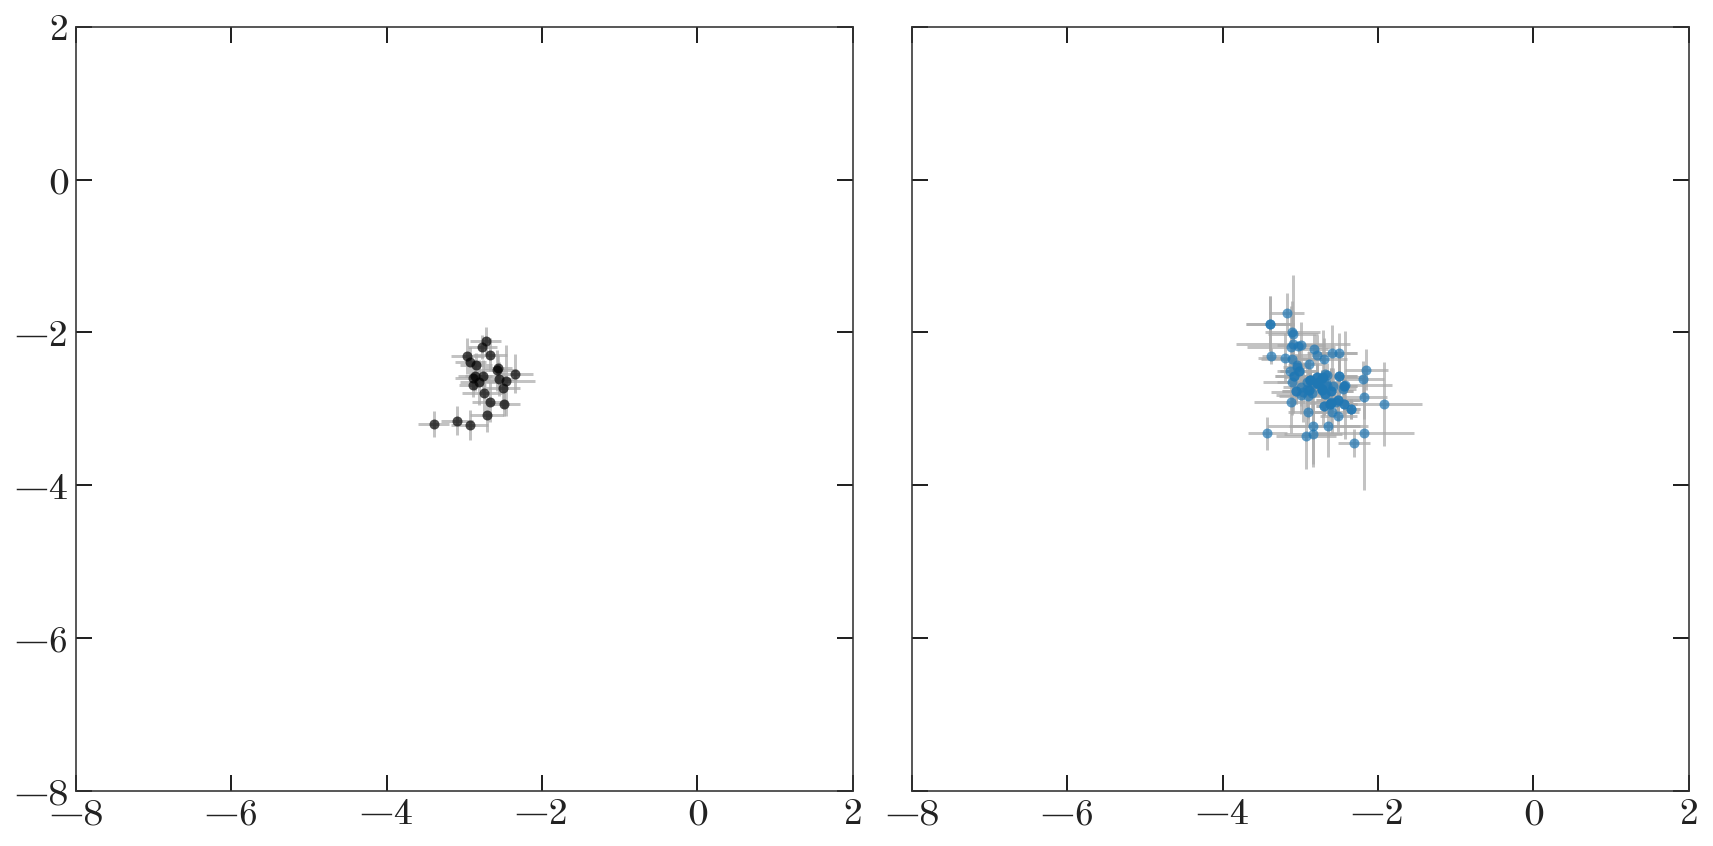

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True, sharey=True)

ax = axes[0]
ax.errorbar(rrl['pmra'], rrl['pmdec'],
            xerr=rrl['pmra_error'],
            yerr=rrl['pmdec_error'],
            marker='o', ls='none', ecolor='#aaaaaa', alpha=0.7)

ax = axes[1]
ax.errorbar(rgb['pmra'], rgb['pmdec'],
            xerr=rgb['pmra_error'],
            yerr=rgb['pmdec_error'],
            marker='o', ls='none', 
            color='tab:blue', ecolor='#aaaaaa', alpha=0.7)

ax.set_xlim(-8, 2)
ax.set_ylim(-8, 2)

fig.tight_layout()

In [106]:
pm1_poly = np.poly1d(np.polyfit(rrl_pal5_c.phi1.degree,
                                rrl_pal5_c.pm_phi1_cosphi2.value, 
                                deg=2, w=1/rrl_pm_cov_pal5[:, 0, 0]))
pm2_poly = np.poly1d(np.polyfit(rrl_pal5_c.phi1.degree,
                                rrl_pal5_c.pm_phi2.value, 
                                deg=2, w=1/rrl_pm_cov_pal5[:, 1, 1]))

(-100, 0)

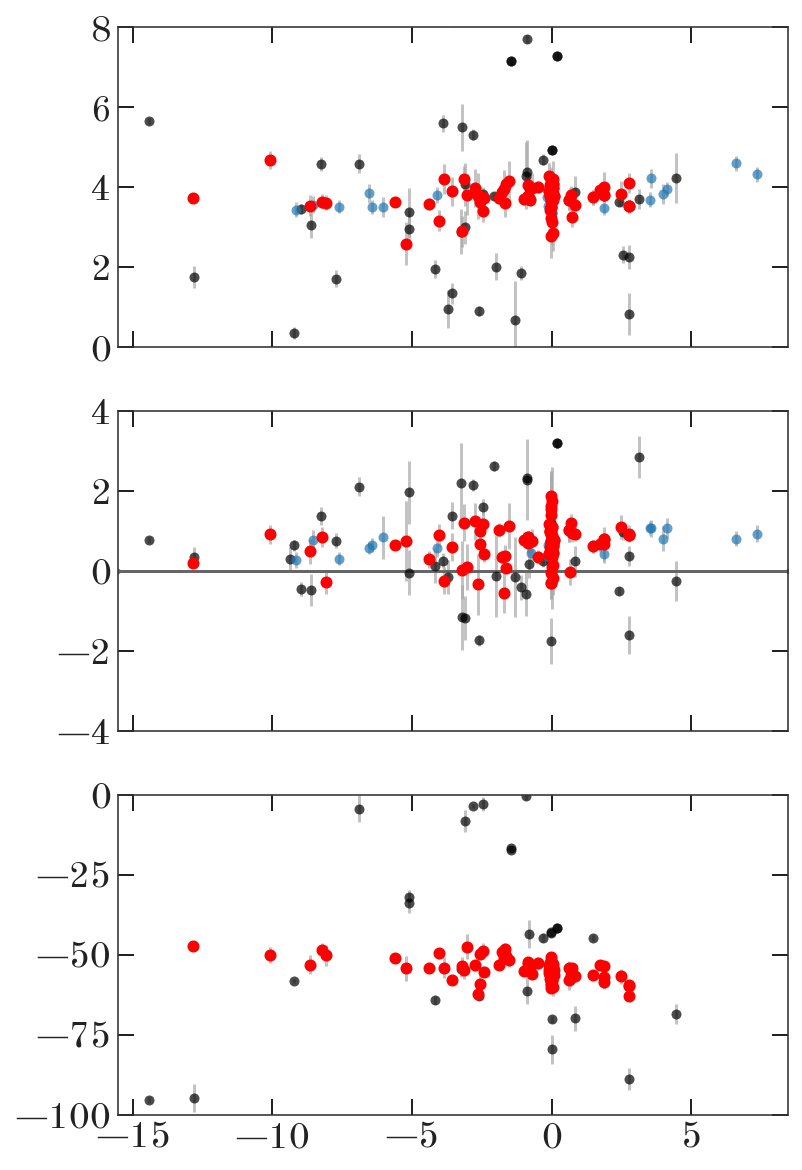

In [110]:
linear_rv_mask = np.abs(rgb_pal5_c.radial_velocity.value - (-2/5*rgb_pal5_c.phi1.degree - 56)) < 8.
pm1_mask = np.abs(rgb_pal5_c.pm_phi1_cosphi2.value - pm1_poly(rgb_pal5_c.phi1.degree)) < 1.5
pm2_mask = np.abs(rgb_pal5_c.pm_phi2.value - pm2_poly(rgb_pal5_c.phi1.degree)) < 1.5
rgb_mask = linear_rv_mask & pm1_mask & pm2_mask

estyle = dict(marker='o', ls='none', ecolor='#aaaaaa', alpha=0.7)

fig, axes = plt.subplots(3, 1, figsize=(6, 10), 
                         sharex=True)

ax = axes[0]
ax.errorbar(rgb_pal5_c.phi1.degree,
            rgb_pal5_c.pm_phi1_cosphi2.value,
            yerr=np.sqrt(rgb_pm_cov_pal5[:, 0, 0]),
            **estyle)
ax.scatter(rgb_pal5_c.phi1.degree[rgb_mask],
           rgb_pal5_c.pm_phi1_cosphi2.value[rgb_mask],
           color='r', zorder=100)

ax.errorbar(rrl_pal5_c.phi1.degree,
            rrl_pal5_c.pm_phi1_cosphi2.value,
            yerr=np.sqrt(rrl_pm_cov_pal5[:, 0, 0]),
            color='tab:blue', **estyle)

ax.set_ylim(0, 8)

ax = axes[1]
ax.errorbar(rgb_pal5_c.phi1.degree,
            rgb_pal5_c.pm_phi2.value,
            yerr=np.sqrt(rgb_pm_cov_pal5[:, 1, 1]),
            **estyle)
ax.scatter(rgb_pal5_c.phi1.degree[rgb_mask],
           rgb_pal5_c.pm_phi2.value[rgb_mask],
           color='r', zorder=100)

ax.errorbar(rrl_pal5_c.phi1.degree,
            rrl_pal5_c.pm_phi2.value,
            yerr=np.sqrt(rrl_pm_cov_pal5[:, 1, 1]),
            color='tab:blue', **estyle)

ax.set_ylim(-4, 4)
ax.axhline(0)

ax = axes[2]
ax.errorbar(rgb_pal5_c.phi1.degree,
            rgb_pal5_c.radial_velocity.value,
            yerr=rgb.vhelio_err,
            **estyle)
ax.scatter(rgb_pal5_c.phi1.degree[rgb_mask],
           rgb_pal5_c.radial_velocity.value[rgb_mask],
           color='r', zorder=100)

ax.set_ylim(-100, 0)

(-10, 10)

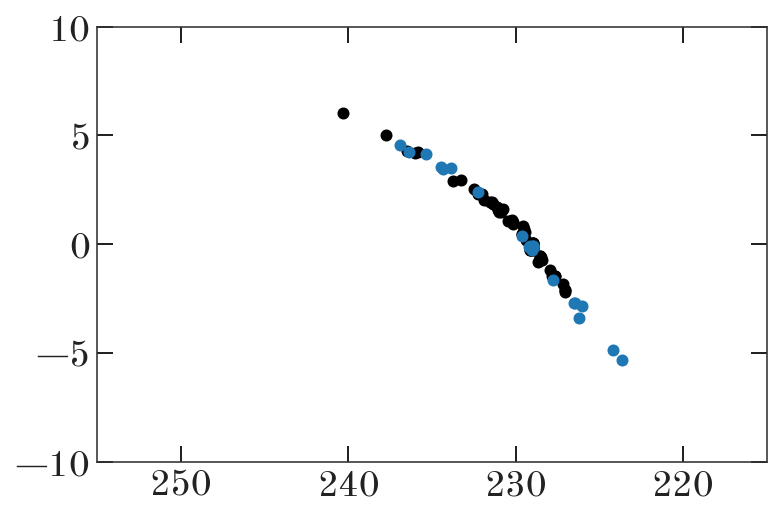

In [112]:
plt.scatter(rgb.ra[rgb_mask], rgb.dec[rgb_mask])
plt.scatter(rrl.ra, rrl.dec)
plt.xlim(255, 215)
plt.ylim(-10, 10)

In [113]:
rgb_mask.sum()

98

In [114]:
rgb.data[rgb_mask].write('../data/pal5/rgb_rough_mask.fits')